# Fast-Neutron Lab
## Data analysis code and lab notebook

### Introduction
* This 'Jupyter Notebook' is your manual, data analysis and log book all at the same time. It consists of individual cells of text or Python code and you can edit or add cells to your heart's content.
* When using the notebook, there are two modes: *command* and *edit* mode. In command mode, you can add, move, run or delete cells. In edit mode, you modify its content. Use the *Esc* key or click outside the cell to leave edit mode. With *shift* + *return* you can run it directly from edit mode.
* When you 'run' a cell it will either be formated or executed depending on whether it is a text cell or a code cell, respectivly. The output will be shown inside the notebook.
* It is best to run the notebook piece-by-piece as we are progressing through the lab. If something doesn't work as expected, try 'Kernel->Restart' to get a fresh working environment.
* Code cells support typical editing features of an IDE, such as tab-complete. You find more info in the 'Help' menu including all keyboard shortcuts!
* **Please note**: The code is not supposed to work out-of-the-box but needs some tweaks from your side to complete all the way through! So if you encounter an error, don't despair, try to fix it and ask for help should you get stuck!

# Set-up the experiment 
* Today, you will start with configuring your set-up. A simplified drawing of the set-up is shown below. Execute the first code cell to show it.
* Have a look at the detector signals you will work with. Take scope traces of one YAP detector and of the liquid scintillator detector. Post the traces here.

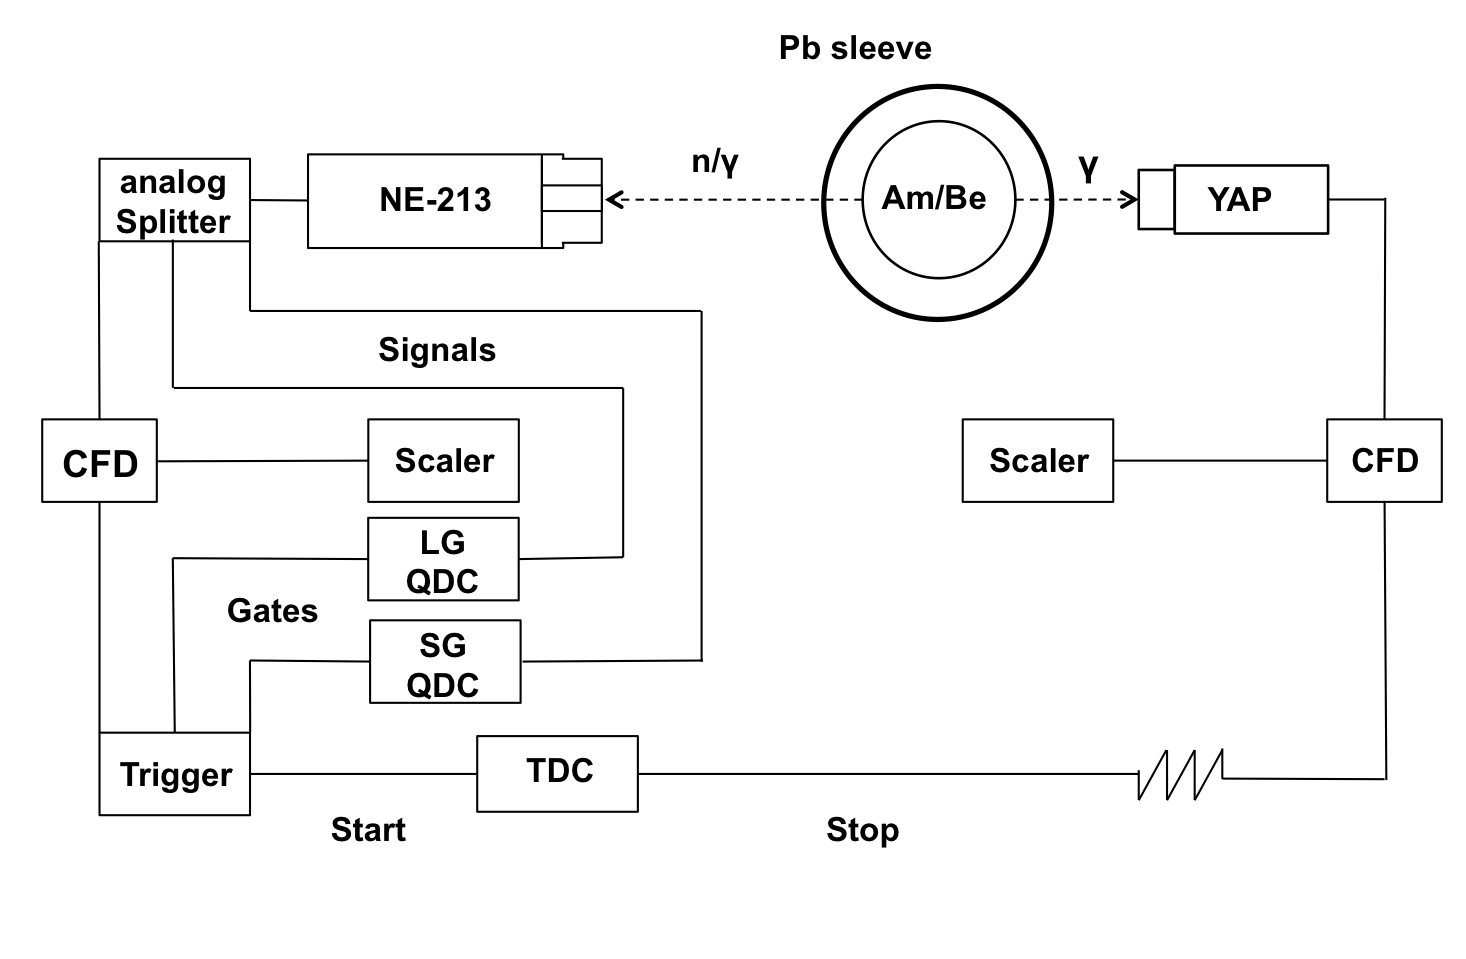

In [1]:
# Is used to show the set-up:
#Load the plotting libraries
from IPython.display import Image
#Plot the setup:
Image("figures/SetUp.png")

## How to transfer data for the analysis
The data is stored in .root files to be used with the *ROOT* data analysis framework. 
To analyse the data here instead, we need to extract the histogrammed data from the file into a format we can easliy import.

For this, use the command *ROOTtoCSV*. 
The prgrams expect two input parameters the name of the *ROOT* file and the name of the histogram you want to extract.

Then copy the data into the folder where you run this Jupyter Notebook from -- or use the upload function in the main Jupyter screen.

## How to run this analysis
Some initialization in your program:
To plot things, you use the matplotlib library. You need to import the library before the first use and initialize the interactive plots inside the notebook:


In [2]:
import numpy as np
import scipy
import matplotlib
# choose a backend for web applications; remove for stand-alone applications:
matplotlib.use('Agg')
import matplotlib.pyplot as plt
# enable interactive notebook plots (
# alternative: use 'inline' instead of 'notebook' for static images)
%matplotlib notebook

# Plotting the time-of-flight data

* The aim is to transform the TDC spectrum into a TOF spectrum.
* First you need to import the data and create a histogram.
* There is already a class ready to be used called histhelpers.

In [3]:
import histhelpers
from histhelpers import getBinCenters
# enter the data from TDC YAP 0
tof = histhelpers.import_hist_from_csv('data_samples/hvt_0.csv') # TODO: put correct file name!
print("Loaded file '{}' imported from '{}'".format(tof.filename, tof.name))

# optionally: 
# define a function to rebin by factor of 2 
# by adding two adjacent bins and joining bin boundaries
def rebin_factor2(spectrum):
    spectrum.data = spectrum.data[1::2] + spectrum.data[::2]
    spectrum.bins = spectrum.bins[::2]
# now apply function to data (as many times as desired):
# rebin_factor2(tof)

fig, axes = plt.subplots() # makes new plot
plt.yscale('log')
axes.plot(getBinCenters(tof.bins), tof.data, label=tof.name, linestyle="steps")

plt.legend()

Loaded file 'data_samples/hvt_0.csv' imported from ' Data219.root'


<IPython.core.display.Javascript object>

# Converting the TDC spectrum a to time-of-flight spectrum

* To determine the $T_0$ reference point you need to find the gamma-flash.
* The precise peak position of the gamma flash can be found by fitting a Gaussian to the data.
* First plot the data:

<IPython.core.display.Javascript object>


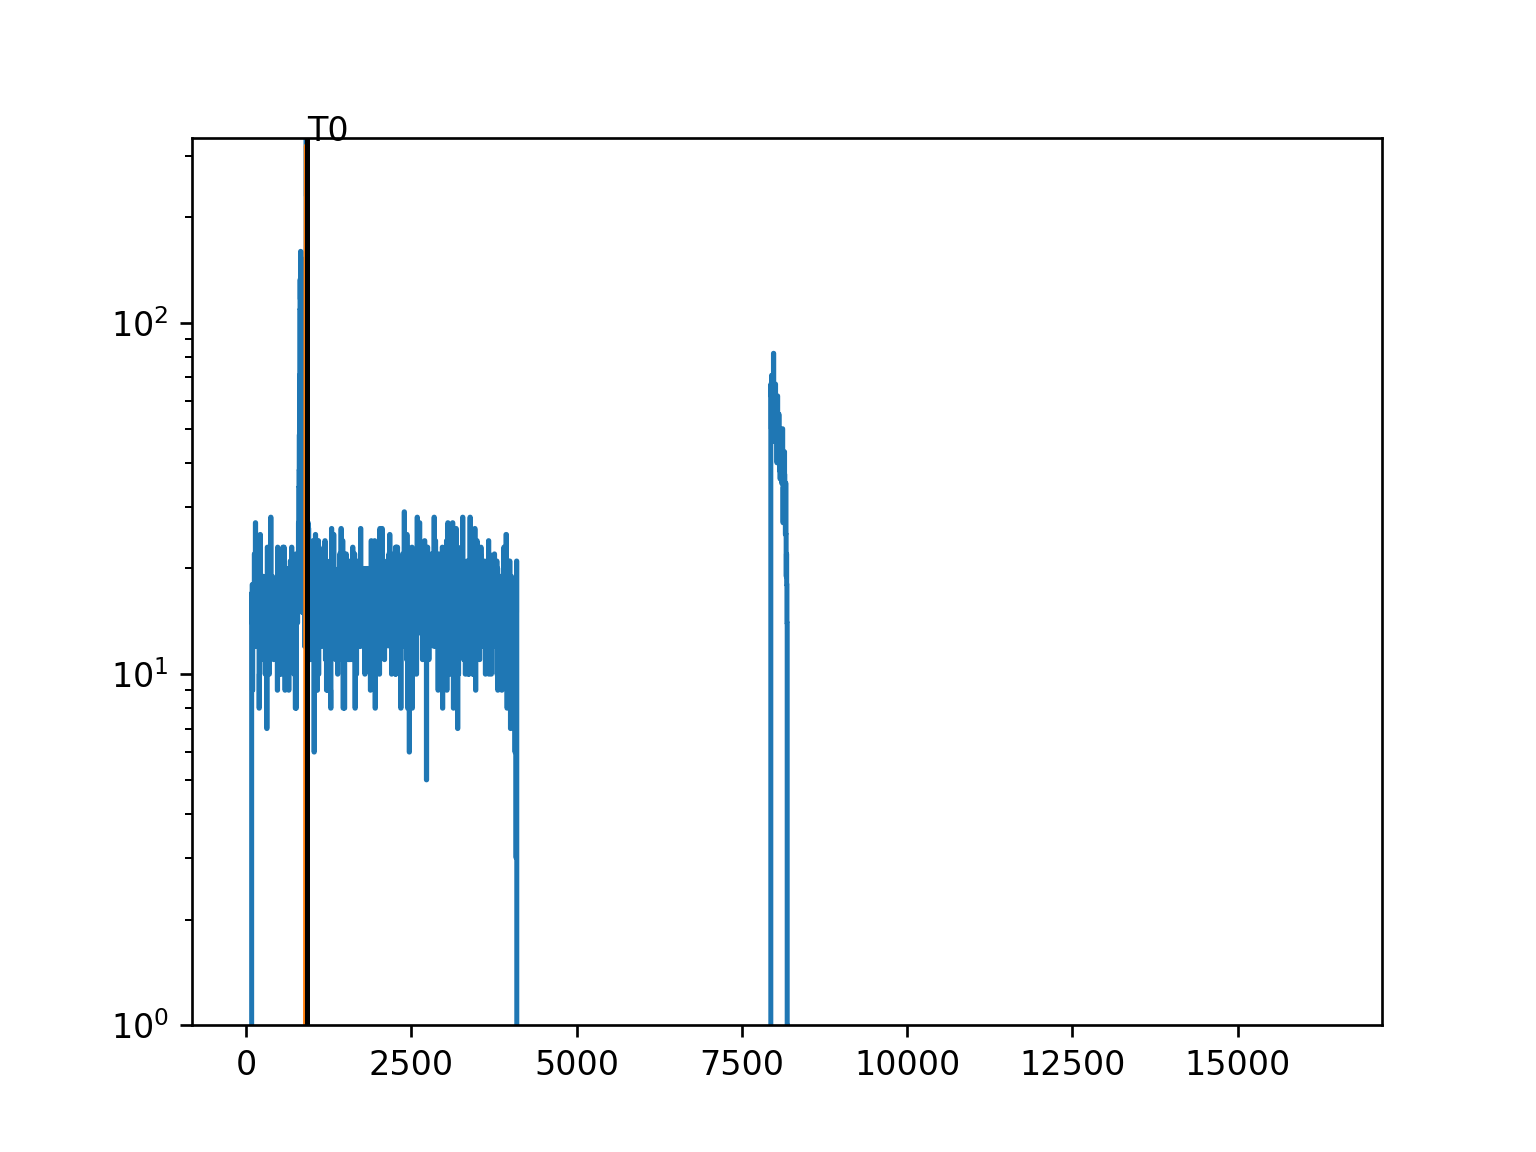

In [4]:
fig, axes = plt.subplots()

# plot data
plt.yscale('log')
plt.ylim(ymin=1, ymax=max(tof.data))
axes.plot(getBinCenters(tof.bins), tof.data, label="TOF data", ls="steps") # ls == linestyle
    

Now adjust the arguments of the routine *fit_gaussians_at_pos* from the *fithelpers.py* file to match the gamma flash position:

In [5]:
import fithelpers
gammaflash_fit = fithelpers.fit_gaussian_at_pos(getBinCenters(tof.bins), tof.data, pos=910)
axes.plot(getBinCenters(tof.bins), gammaflash_fit.value(getBinCenters(tof.bins)), label="Gauss Fit")

Now put the correct values in to calcuate the reference time $T_0$:

In [6]:
#Enter the distance from detector to neutron source:
distance =  0.8 # in [m]
speed_of_light = 2.99792458e8 # in [m/s]
#Add TDC resolution 
seconds_per_TDC_channel = 265e-12 # in s/ch
T0 = gammaflash_fit.mu + (distance / speed_of_light)/seconds_per_TDC_channel
print ("T0 calculated to be: {}".format(T0))
from IPython.display import Math
#Find gamma TOF
#added the TDC resolution in ns/ch
Math('\Delta t_{{0 \gamma}} = {} [\\text{{ch}}] \equiv {} [\\text{{s}}]'.format(
        round(T0-gammaflash_fit.mu), round(T0-gammaflash_fit.mu)*seconds_per_TDC_channel))

# add text with T0 indicated
axes.text(T0, gammaflash_fit.A, "T0")
axes.plot((T0, T0), (1, gammaflash_fit.A), 'k-')

T0 calculated to be: 920.9791536645846


For clarity, let's put the axis into the correct time binning, invert it and shift the zero position to T0

<IPython.core.display.Javascript object>


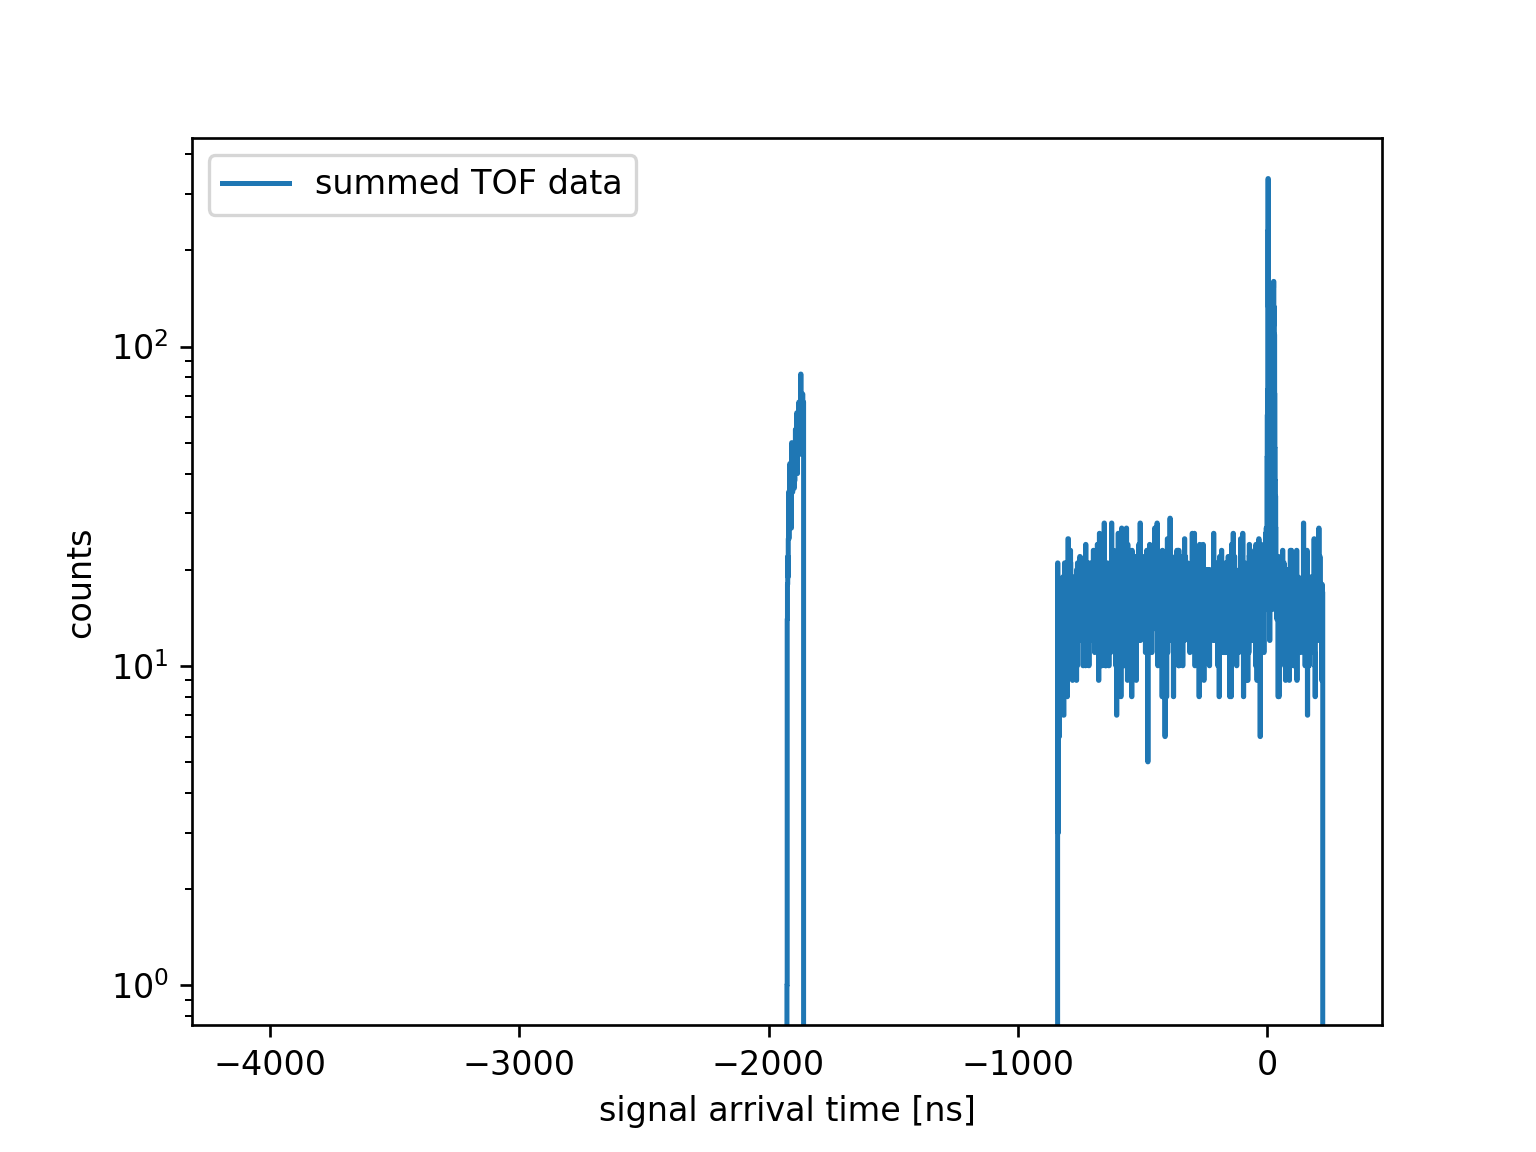

In [7]:
import copy

# copy spectrum into new data structure (before messing with it)
tof_in_ns = copy.deepcopy(tof)
# now align the axis so that 0 =^= T0 and convert TDC channel to time [ns]
tof_in_ns.bins = ((-1) * tof.bins + T0) * seconds_per_TDC_channel
tof_in_ns.bins *= 1e9 # convert s in ns
# plot the result
fig, axes = plt.subplots()
axes.plot(getBinCenters(tof_in_ns.bins), tof_in_ns.data, label="summed TOF data", ls="steps")
plt.xlabel('signal arrival time [ns]')
plt.ylabel('counts')
plt.yscale('log')
plt.legend()

# Clean-up of the spectra and background subtraction
Let's remove "unphysical" part with $t<0$ of the ToF spectrum

<IPython.core.display.Javascript object>


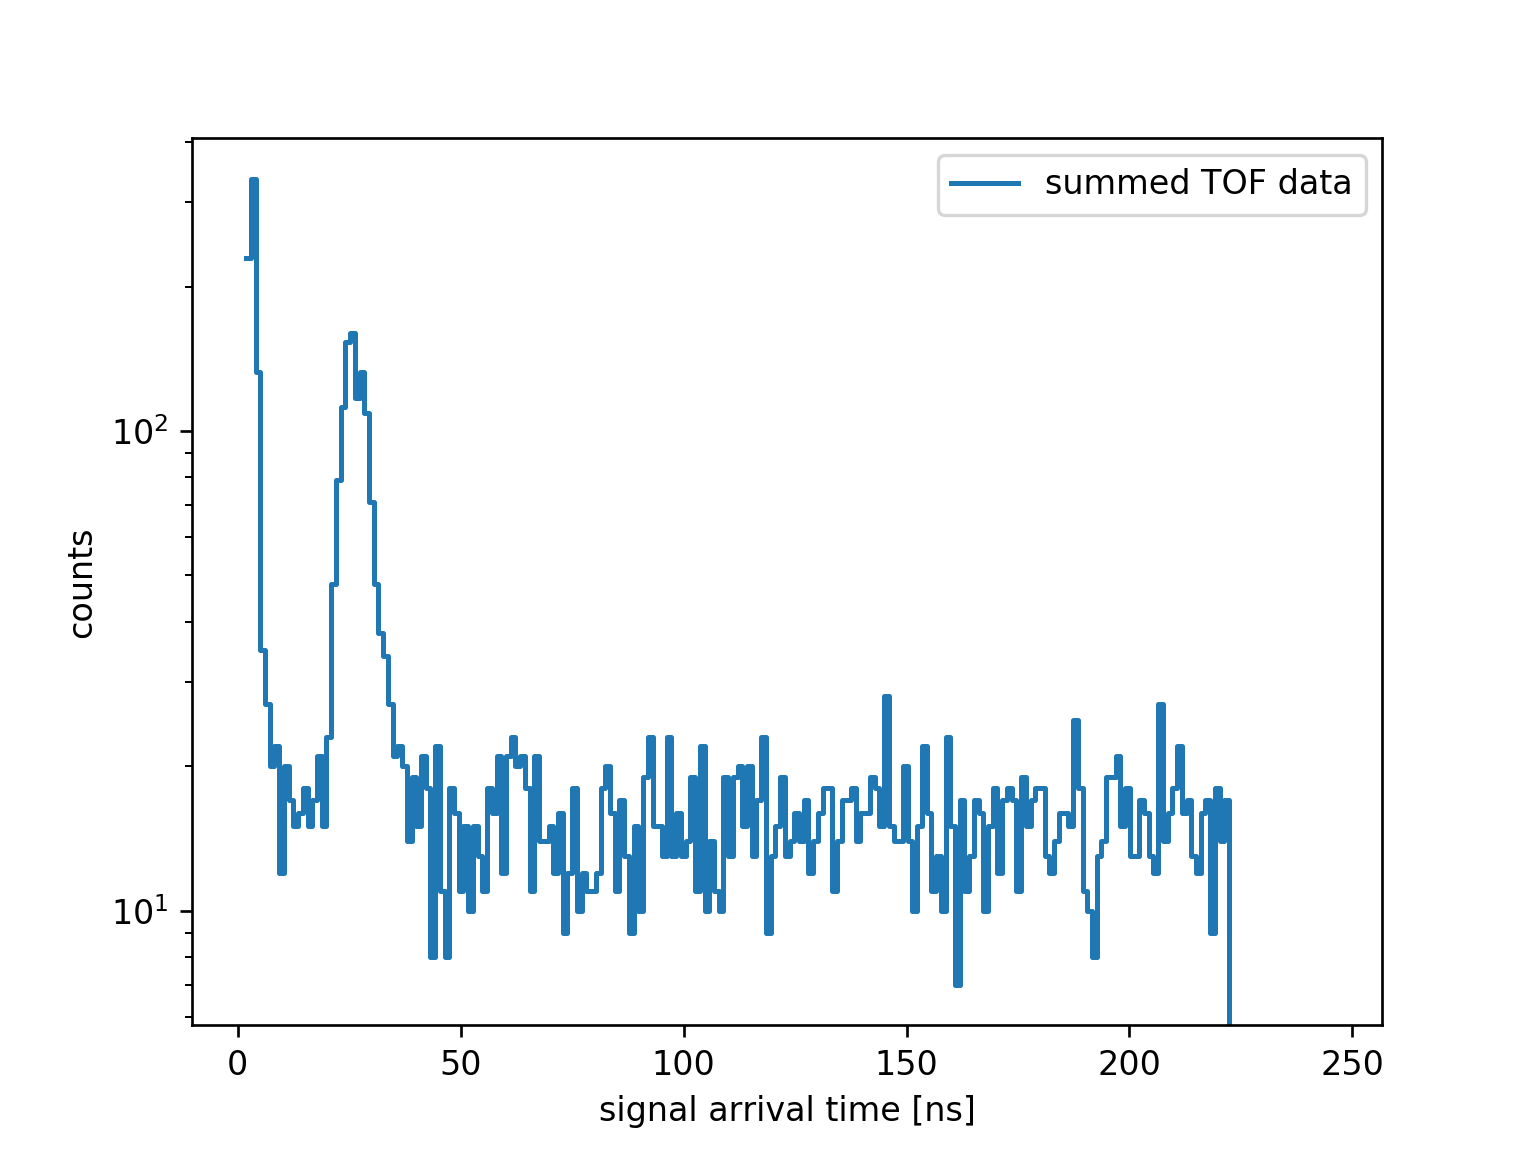

In [8]:
# make copy of spectrum first
tof_stripped = copy.deepcopy(tof_in_ns)

## remove some of the data that would mess up our calculation:
## - find all bins with x > 0, remember last index (just for the very curious -- why last index and not first: the order in memory stays but we flipped the axis when we multiplied with -1 above)
idx_low = np.where(tof_stripped.bins>0)[0][-1]
#idx_high = np.where(Tn.bins>100)[0][-1]

## strip all other bins to remove those with x < 0
tof_stripped.bins = tof_stripped.bins[0:idx_low]
tof_stripped.data = tof_stripped.data[0:idx_low-1] # mind the offset, len(bins) = len(data)+1 !
# plot the result
fig, axes = plt.subplots()
axes.plot(getBinCenters(tof_stripped.bins), tof_stripped.data, label="summed TOF data", ls="steps")
plt.xlabel('signal arrival time [ns]')
plt.ylabel('counts')
plt.yscale('log')
plt.legend()

### Now, we can subtract the random background from the spectrum:

(And maybe contemplate: what are the implications? Is this a correction or a purely cosmetic step?)

<IPython.core.display.Javascript object>


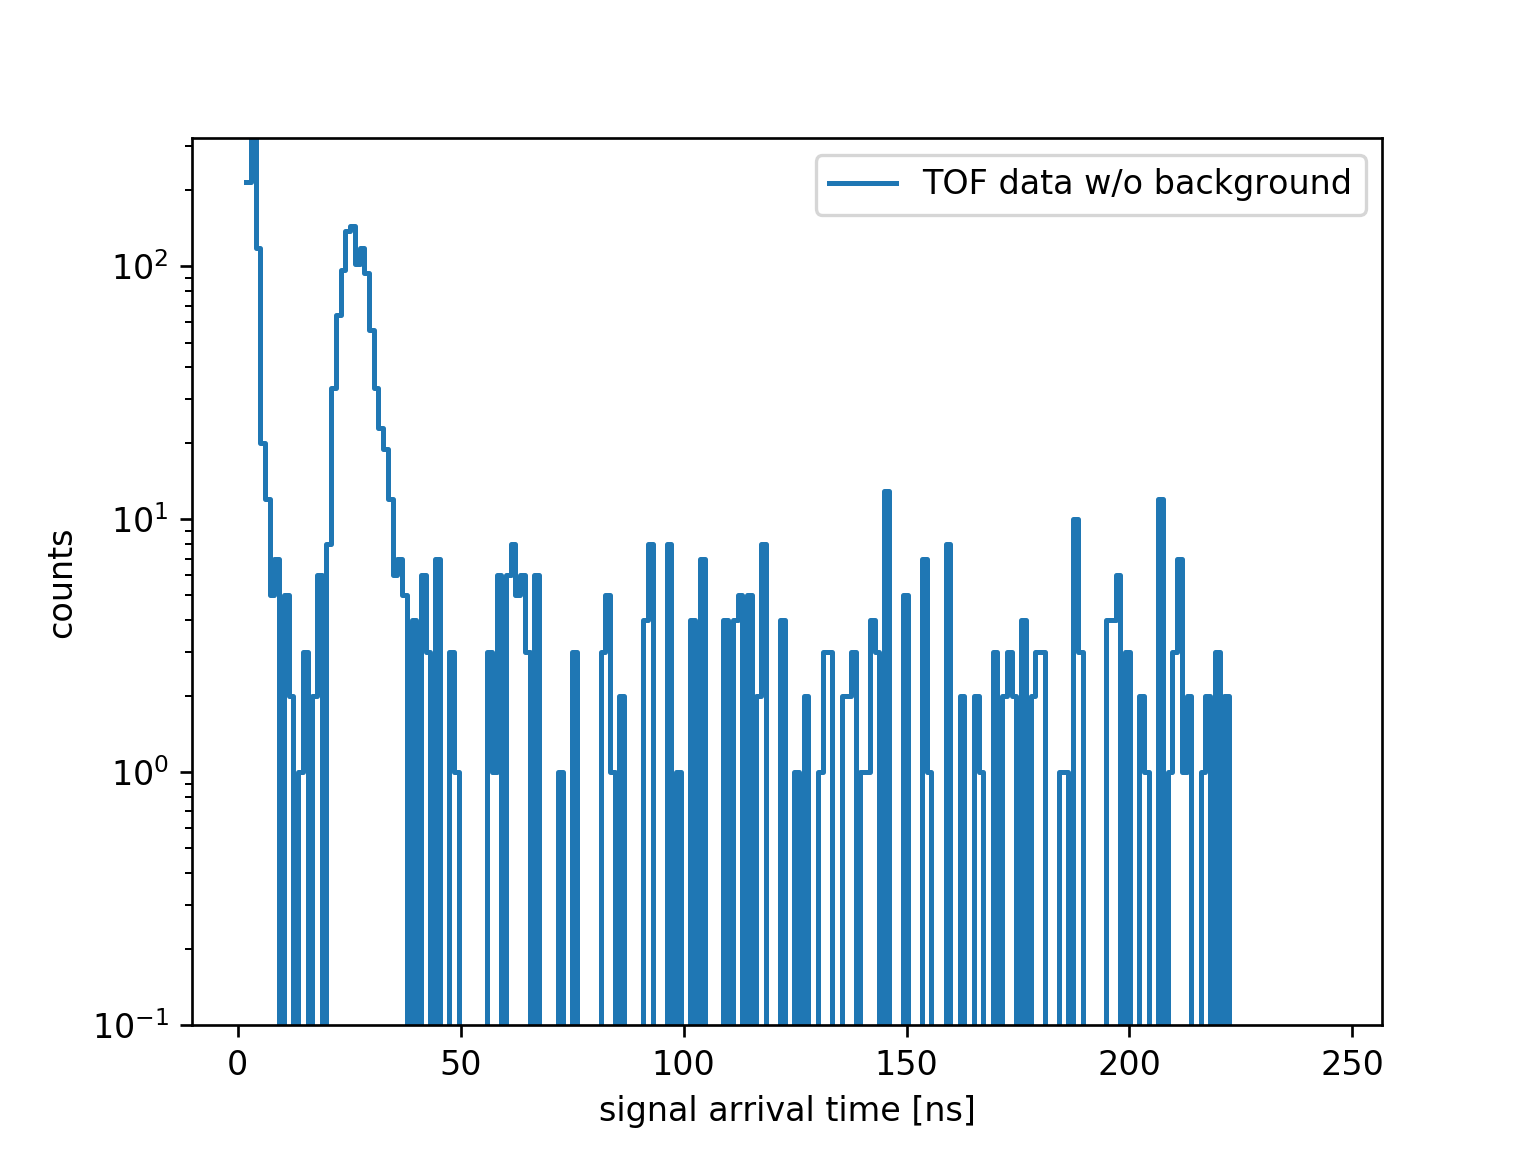

In [9]:
tof_wo_bckgrd = copy.deepcopy(tof_stripped)
# subtract background
tof_wo_bckgrd.data -= 15
# values < 0 are unphysical -- set to zero instead
tof_wo_bckgrd.data[tof_wo_bckgrd.data < 0] = 0
# plot the result
fig, axes = plt.subplots()
plt.ylim(0.1,max(tof_wo_bckgrd.data))
axes.plot(getBinCenters(tof_wo_bckgrd.bins), tof_wo_bckgrd.data, ls="steps", label="TOF data w/o background")
plt.xlabel('signal arrival time [ns]')
plt.ylabel('counts')
plt.yscale('log')
plt.legend()

# Convert the time-of-flight to an energy spectrum

<IPython.core.display.Javascript object>


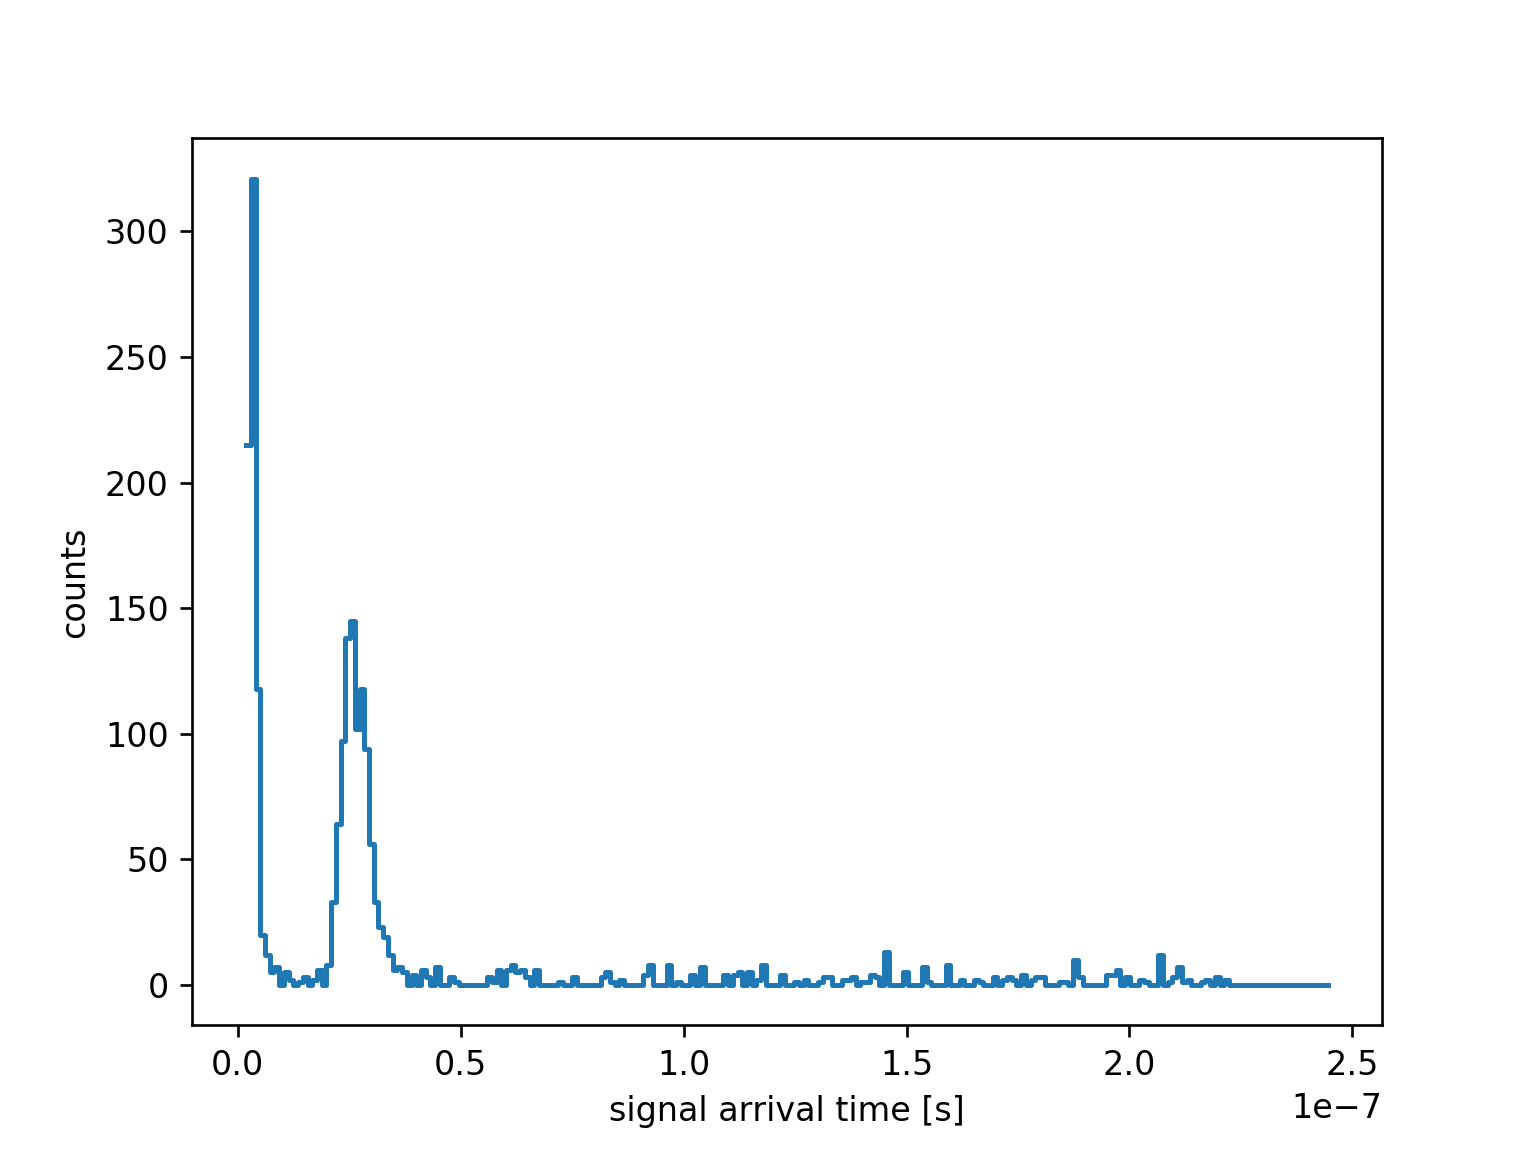

/Users/hperrey/Library/Python/3.6/lib/python/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in sqrt


<IPython.core.display.Javascript object>


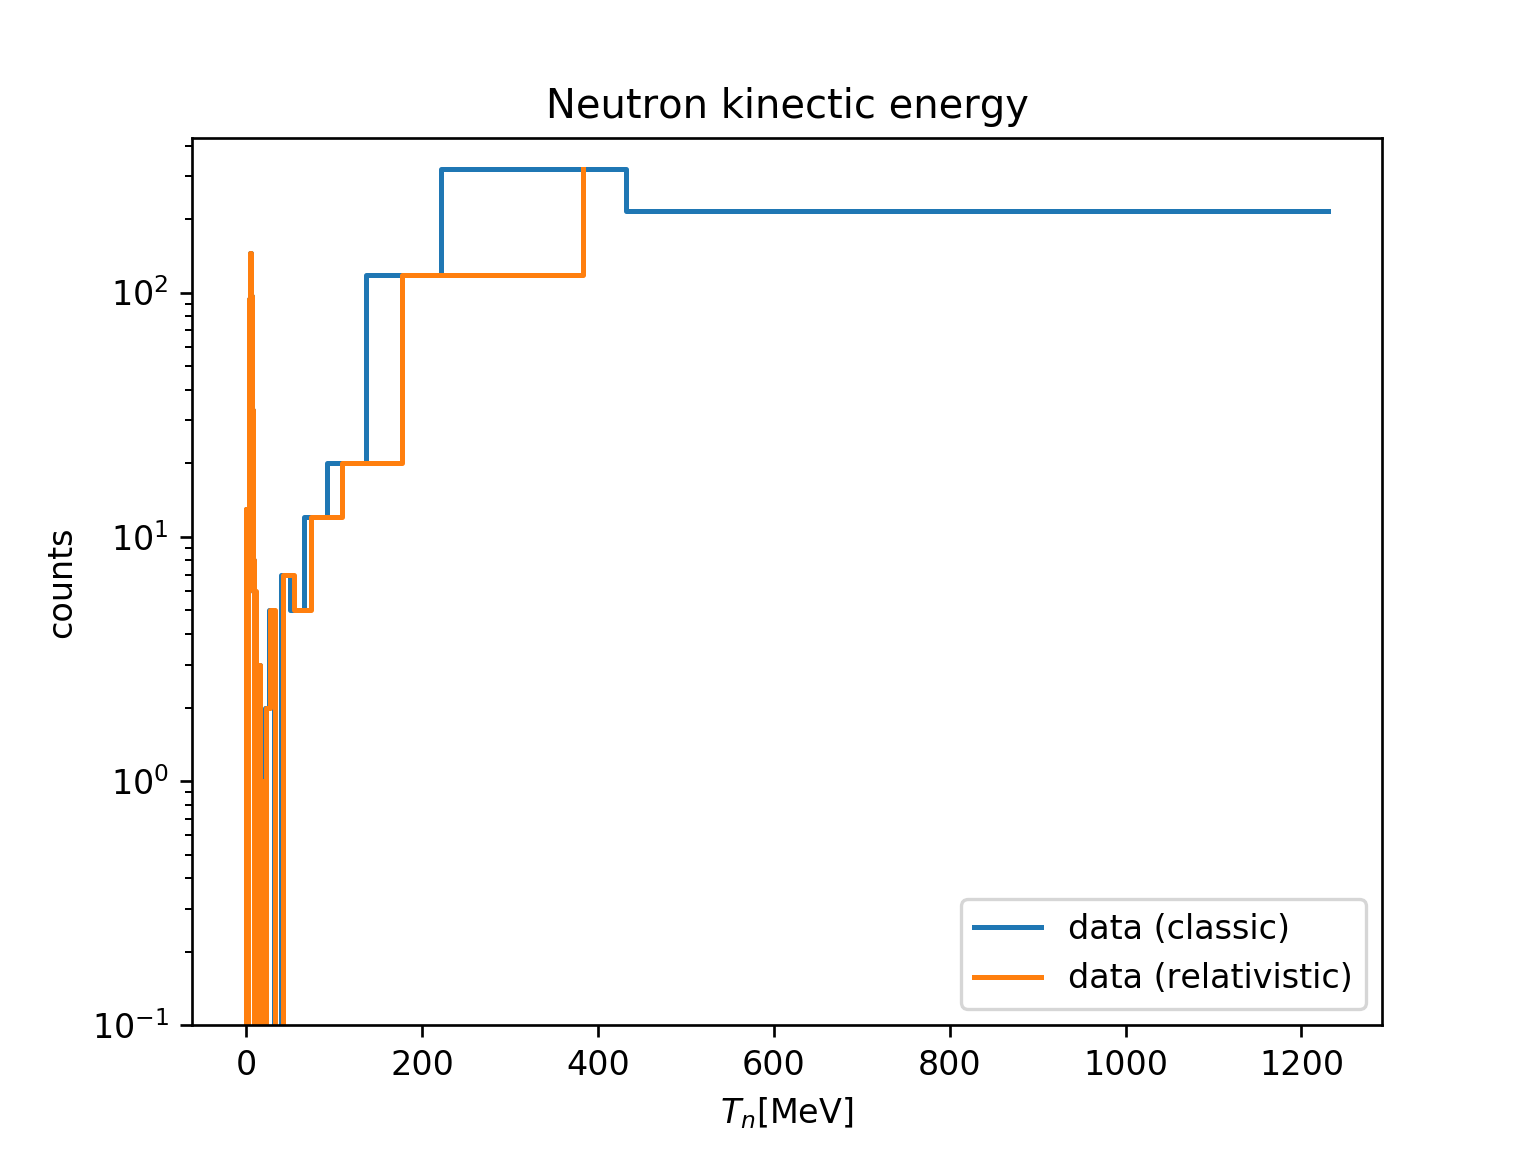

In [10]:
## constants:
#Add neutron mass
M_n = 939  ## mass of n in MeV/c**2

Tn = copy.deepcopy(tof_wo_bckgrd)
Tn.bins *= 1e-9 # convert to seconds

# show the raw data once more for clarity
fig, axes = plt.subplots()
axes.plot(getBinCenters(Tn.bins), Tn.data, label="data (cut)", linestyle="steps")
plt.xlabel('signal arrival time [s]')
plt.ylabel('counts')

## non-relativistic/classic approach:
Tn_cls = copy.deepcopy(Tn)
Tn_cls.bins = 0.5 * (M_n / pow (speed_of_light, 2)) * ( pow(distance, 2) / pow(Tn_cls.bins, 2) )
## relativistic approach: B. Nilsson PhD thesis, LU, 2003, equation 2.7
Tn_rlv = copy.deepcopy(Tn)
beta = 1. / ( 1. + ((Tn_rlv.bins - distance / speed_of_light) * speed_of_light / distance))
Tn_rlv.bins = M_n * ( ( 1. / np.sqrt(1. - pow(beta, 2))) - 1. )

# plot the result
fig, axes = plt.subplots()
axes.plot(getBinCenters(Tn_cls.bins), Tn_cls.data, label="data (classic)", linestyle="steps")
axes.plot(getBinCenters(Tn_rlv.bins), Tn_rlv.data, label="data (relativistic)", linestyle="steps")

plt.xlabel(r'$T_n \mathrm{[MeV]}$')
plt.ylabel('counts')
plt.yscale('log')
plt.ylim(ymin=0.1)
plt.title("Neutron kinectic energy")
plt.legend()

# Discussion of systematic uncertainties
* what variables enter into the energy spectrum calculation?
* what are their uncertainties and how do they affect the result? How can you practically estimate this effect?
* what is the probability and precision for measuring a fast neutron with the tagging method?
* what are advantages and disadvantages of this method?
* how could it be improved?

... and: would you be interested in learning more in an *Advanced Neutron Tagging Lab*? ;)